<h1>DATA PREPROCESSING</h1>

<h2>EDA</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

In [2]:
final_dataset=pd.read_csv('final_dataset2.csv')

In [3]:
final_dataset

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
101470,Just realized that the Windows partition of my...,positive
101471,Just realized that my Mac window partition is ...,positive
101472,Just realized the windows partition of my Mac ...,positive
101473,Just realized between the windows partition of...,positive


In [4]:
import nltk
import re
from nltk.corpus import stopwords

sw_list=stopwords.words('english')
word_count={
    "positive":[],
    "negative":[],
    "neutral":[],
    "irrelevant":[]
}

pattern=re.compile("[^\w ]")

for text,target in zip(final_dataset.text,final_dataset.sentiment):
    text=re.sub(pattern,"",text).lower().split()
    text=[word for word in text if word not in sw_list]
    word_count[target].extend(text)

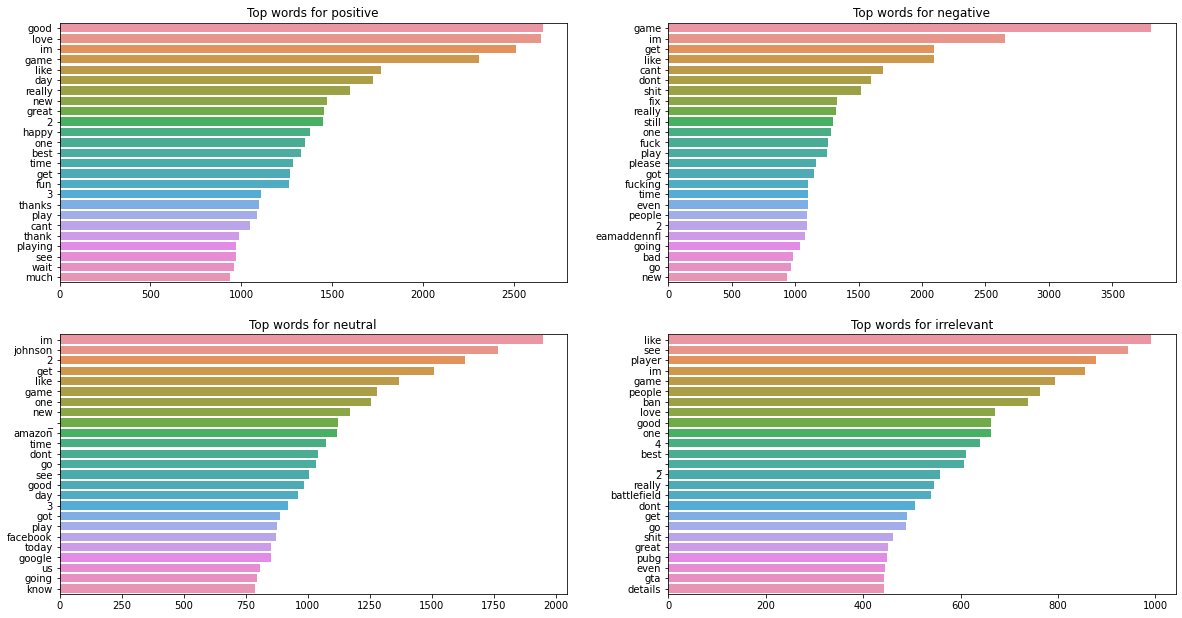

In [5]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_count.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

<h2>PREPROCESSING</h2>

In [6]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ganes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=10, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()]                          # delete nans
        X = X[~X.duplicated()]                      # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

In [8]:
pr=Preprocessor()

In [9]:
data_train=final_dataset
y_final=final_dataset.sentiment

In [10]:
data_train.text.info()

<class 'pandas.core.series.Series'>
RangeIndex: 101475 entries, 0 to 101474
Series name: text
Non-Null Count   Dtype 
--------------   ----- 
101475 non-null  object
dtypes: object(1)
memory usage: 792.9+ KB


In [11]:
y_final.info()

<class 'pandas.core.series.Series'>
RangeIndex: 101475 entries, 0 to 101474
Series name: sentiment
Non-Null Count   Dtype 
--------------   ----- 
101475 non-null  object
dtypes: object(1)
memory usage: 792.9+ KB


In [12]:
data_train_pr = pr.transform(data_train['text'])
data_train_pr = pd.DataFrame.sparse.from_spmatrix(data_train_pr, columns=pr.vectorizer.get_feature_names_out())
y_final = y_final[y_final.index.isin(pr.train_idx)]
y_final.index = data_train_pr.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 96965/96965 [00:00<00:00, 185839.52it/s]


Removing numbers...


100%|██████████| 96965/96965 [00:00<00:00, 920485.09it/s]


Lemmatizing...


100%|██████████| 96965/96965 [05:34<00:00, 289.98it/s]


Fitting vectorizer...
Vectorizing...


In [13]:
data_train_pr

,aaa,aaron,ab,abandon,abandon sanction,abc,ability,able,able get,able go,...,zero dawn,zip,zoe,zombie,zone,zonestream,zonestream cx,zoom,zuckerberg,zy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Training</h1>

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data_train_pr,y_final,test_size=0.4,random_state=0)

In [ ]:
X_train

In [ ]:
y_train

<h2> Logistic regression </h2>

In [15]:
# from sklearn.metrics import classification_report
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression
# from scipy.stats import uniform, randint
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.metrics import confusion_matrix

In [16]:
# def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1_weighted'):
#     kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

#     cv = RandomizedSearchCV(model,
#                         params,
#                         cv=kf,
#                         scoring=scoring,
#                         return_train_score=True,
#                         n_jobs=-1,
#                         verbose=2,
#                         random_state=1
#                         )
#     cv.fit(X_train, y_train)

#     print('Best params', cv.best_params_)
#     return cv

In [17]:
# rs_parameters = {
#     'penalty': ['l2', 'l1', 'elasticnet'],
#     'C': uniform(scale=10),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
#     'l1_ratio': uniform(scale=10)
#     }

In [18]:
# lr = LogisticRegression()
# model_cv_lr = train_cv(lr, X_train, y_train, rs_parameters)

# bestimator_lr = model_cv_lr.best_estimator_

In [19]:
# print(classification_report(y_test, bestimator_lr.predict(X_test)))

In [20]:
# from sklearn.metrics import confusion_matrix
# sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
# plt.show()

<h2>Pytorch Lightning</h2>

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks import LearningRateMonitor
from IPython.display import clear_output
import numpy as np

torch.manual_seed(42)

def plot_loss(losses, title=''):
    """
    plots and saves loss progression while fitting
    """
    if len(losses) < 3:
        return

    pos = np.vstack(losses)
    x, y = pos.T
    plt.clf()
    plt.ion()
    plt.figure(figsize=(9, 5))
    plt.plot(x, y)
    plt.title(title)
    clear_output(wait=True)
    plt.show()

class NNSentimentClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.model = nn.Sequential(
        nn.Linear(8000, 1000),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1000, 100),
        nn.Tanh(),
        self.dropout,
        nn.Linear(100, 1000),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1000, 10),
        nn.ReLU(),
        self.dropout,
        nn.Linear(10, 4)
        )
        self.acc_train_loss = []
        self.acc_val_loss = []
    
    def forward (self, x):
        prediction = self.model(x)
        return prediction
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
    
    def test_step(self, test_batch, batc_idx):
        x, y = test_batch
        y = y.long()
        prediction = model.forward(x.float())
        preds = torch.argmax(prediction, dim=1)

        return preds

In [22]:
# data
target_to_idx = {
    'Irrelevant': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3
    }


x_tensor=torch.from_numpy(X_train.to_numpy().astype(np.float64))
y_tensor = torch.from_numpy(y_train.map(target_to_idx).values.astype(np.float64))
train_data_tensor = data_utils.TensorDataset(x_tensor, y_tensor)
val_size = int(len(train_data_tensor)*0.2)
train_size = len(train_data_tensor)- int(len(train_data_tensor)*0.2)
train_data_tensor, val_data_tensor = random_split(train_data_tensor, [train_size, val_size])
train_loader = DataLoader(train_data_tensor, batch_size=32)
val_loader = DataLoader(val_data_tensor, batch_size=1)

In [25]:
# model
model = NNSentimentClassifier()
# training

trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=0.5, max_epochs=50)
trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\ganes\OneDrive\Documents\GitHub\Sentment-analysis\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | softmax | Softmax    | 0     
1 | dropout | Dropout    | 0     
2 | model   | Sequential | 8.2 M 
---------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
16.488    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8000 and 8032x1000)